In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from openalexnetwork import EntitiesCrawler, createCitationGraph
from igraph import plot

/Users/rezatabrizi/Library/Caches/pypoetry/virtualenvs/citation-network-paDbNT47-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Option 1: Creating a Citation Graph based on a general query

### Input: 
- Search: Search across query parameter: titles, abstracts, and fulltext
- Filter: Filter Work objects (OpenAlex response when querying publications). There are a lot of filter options. 

### Output: 
- An iterator that iterates over all the work entities that meet the input requirements. The output can be limited to a max number. 

### Intuition 
The dataset generated based on this query will likely be more suitable for general graph prediciton and analysis tasks. Since this search is very general, and can be customized using the `serach` and `filter` parameter, it is more general purpose.

In [ ]:
alexCrawler = EntitiesCrawler("reza.aghazadehtabrizi@utdallas.edu")
filters = {
    "is_paratext" : "false",
    "language": "en",
    "open_access.is_oa": "true",
    "from_publication_date": "2020-01-01",
    "to_publication_date": "2020-01-01"
}

search = "Machine Learning in Finance"
search_entities = alexCrawler.getEntities(filters, search, maxEntities=100000000)
search_graph = createCitationGraph(entities=search_entities)

INFO - [{}] Total entities found: 25614, Pages to fetch: 129
Creating the citation graph:   8%|▊         | 2001/25614 [00:16<02:59, 131.28it/s]

In [ ]:
search_graph.vs[0]

igraph.Vertex(<igraph.Graph object at 0x1274ac450>, 0, {'id': 'https://openalex.org/W4385245566', 'doi': 'https://doi.org/10.48550/arxiv.1706.03762', 'title': 'Attention Is All You Need', 'publication_year': 2017, 'publication_date': '2017-01-01', 'language': 'en', 'authorships': '[{"author_position": "first", "author": {"id": "https://openalex.org/A5103024730", "display_name": "Ashish Vaswani", "orcid": "https://orcid.org/0000-0002-7794-2085"}, "institutions": [], "countries": [], "is_corresponding": false, "raw_author_name": "Vaswani, Ashish", "raw_affiliation_strings": [], "affiliations": []}, {"author_position": "middle", "author": {"id": "https://openalex.org/A5021878400", "display_name": "Noam Shazeer", "orcid": null}, "institutions": [], "countries": [], "is_corresponding": false, "raw_author_name": "Shazeer, Noam", "raw_affiliation_strings": [], "affiliations": []}, {"author_position": "middle", "author": {"id": "https://openalex.org/A5005777963", "display_name": "Niki Parmar",

### Custom Profiler to measure performance of the API and Accuracy of the results

In [ ]:
search_entities._api.profiler.get_summary()

{'total_time': 11.066457033157349,
 'api_calls': 46.0,
 'average_time': 0.24057515289472498,
 'Errors': {}}

## Graph - LOL 
There are obviously 9k Nodes here. Pretty hard to see the graph in 600x600 pixels.

In [ ]:
plot(search_graph, bbox=(600, 600), margin=20)

## Option 2: Creating a Citation Graph based on a direct cascading query (using BFS)

### Input: 
- root: List of Open Alex Work IDs to use as the roots of the cascade. 
- maxLevel: Max level of references to expand. 
- maxNodes: Max number of nodes to query. 

### Output: 
- An iterator that iterates over all the references of publications until all the references are retrieved or the maxlevel or maxnodes are reached. 

### Intuition
For studying cascades, this kind of query is more likely to give us deeper cascades. It is a more direct way to generate a graph containing more direct cascades. However, the drawback is that the graph is very specific as it might be limited to the selected roots. Where as in Option 1 with a general search, the cascades are in a more random fashion. 


In [ ]:
# This is a BFS Citation Graph based on the Work ID
citation_entities = alexCrawler.citationBFS(root=["W3001111845"], maxLevels=2, maxNodes=1000)
citation_graph = createCitationGraph(citation_entities)

Creating the citation graph: 10it [00:01,  9.21it/s]WARNING - [{'WID': 'W2232945224'}] Rate limit hit (HTTPS 429). Retrying in 2.0 seconds...
Creating the citation graph: 19it [00:04,  5.63it/s]WARNING - [{'WID': 'W2809583854'}] Rate limit hit (HTTPS 429). Retrying in 2.0 seconds...


### Profiler
- Errors are the known and unknown errors while querying the API. If there are server errors or certain API errors we can double check the dataset for accuracy. In this case we only has a 429 rate limit error. The API calling function is robut in the sense that it does retries with exponential back-offs upon hitting a rate limit. In this case all the works were successfully retrieved.

In [ ]:
alexCrawler._api.profiler.get_summary()

{'total_time': 6.144695997238159,
 'api_calls': 33.0,
 'average_time': 0.18620290900721695,
 'Errors': {429: 1}}

### Graph
This graph is a lot more interpretable becasue it is smaller. The edge direction is : (paper B cites paper A).

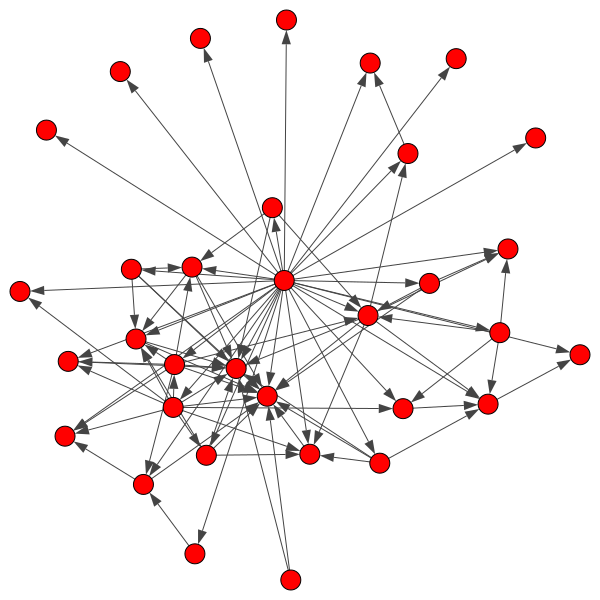

In [ ]:
plot(citation_graph, bbox=(600, 600), margin=20)

## Very useful Functions

In [ ]:
from openalexnetwork import save_citation_graph_to_csv, create_citation_graph_from_csv

### Save the graph and its metadata to a csv

In [ ]:
save_citation_graph_to_csv("test.csv", citation_graph)

## Read the graph from a csv

In [ ]:
g_from_csv = create_citation_graph_from_csv("test.csv")

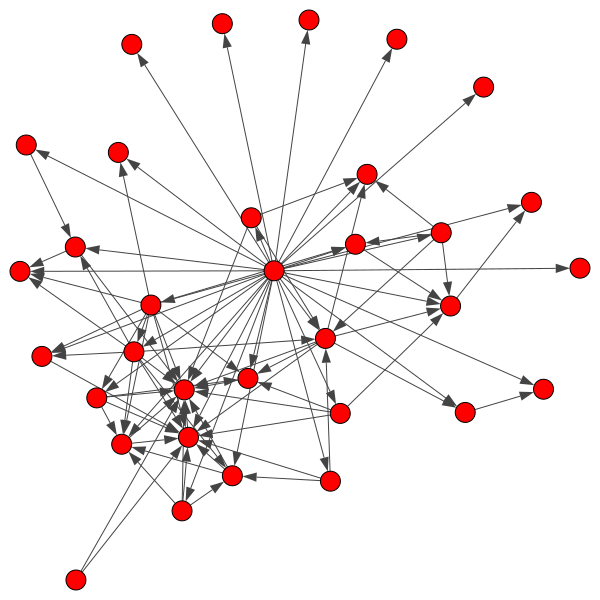

In [ ]:
plot(g_from_csv, bbox=(600, 600), margin=20)